# 10数据聚合与分组运算
以一种自然的方式对数据进行切片、切块和摘要等操作。
SQL语言可以方便的对数据进行连接、过滤、转换和聚合。
但是SQL语言的分组运算能力有限。
python和pandas可以执行复杂的多的分组运算。
* 计算分组摘要统计，如计数、平均值、标准差，或自定义函数。
* 计算分组的概述统计，比如数量、平均值或标准差，自定义函数。
* 应用组内转换或其他运算，如规格化、线性回归、排名或选取子集等。
* 计算透视表或交叉表。
* 执行分位数分析以及其他统计分组分析。

## 10.1GroupBy机制
拆分->函数计算->合并
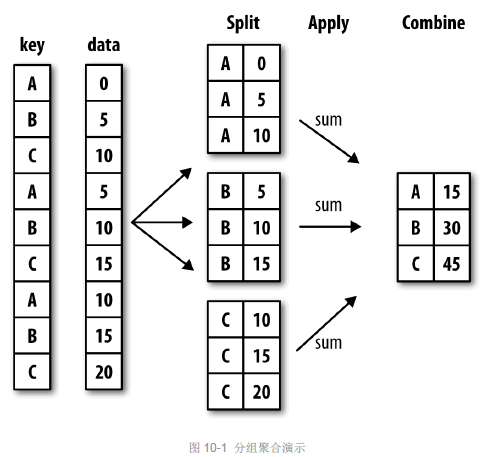




In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.DataFrame({'key1':['a','a','b','b','a'],
                  'key2':['one','two','one','two','one'],
                  'data1':np.random.randn(5),
                  'data2':np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,0.508162,-2.581229
1,a,two,0.014443,1.077285
2,b,one,1.570714,-1.740048
3,b,two,-1.523176,-0.764031
4,a,one,0.375082,0.749013


In [3]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [4]:
grouped.mean()

key1
a    0.787351
b    0.129718
Name: data1, dtype: float64

In [5]:
means = df['data1'].groupby([df['key1'],df['key2']]).mean()
means

key1  key2
a     one     0.975433
      two     0.411188
b     one     0.407616
      two    -0.148180
Name: data1, dtype: float64

In [6]:
means.unstack()

key2,one,two
key1,,
a,0.975433,0.411188
b,0.407616,-0.148180


* 对Series进行分组

In [7]:
states = np.array(['Ohio','California','California','Ohio','Ohio'])
years = np.array([2005,2005,2006,2005,2006])

In [8]:
df['data1'].groupby([states,years]).mean()

California  2005    0.411188
            2006    0.407616
Ohio        2005    0.666804
            2006    0.469078
Name: data1, dtype: float64

### 10.1.1 对分组进行迭代

In [9]:
for name,group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one  1.481788  0.973079
1    a  two  0.411188 -0.694239
4    a  one  0.469078 -0.674495
b
  key1 key2     data1     data2
2    b  one  0.407616  0.325499
3    b  two -0.148180 -0.833169


In [3]:
for (k1,k2),group in df.groupby(['key1','key2']):
    print((k1,k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one  0.508162 -2.581229
4    a  one  0.375082  0.749013
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.014443  1.077285
('b', 'one')
  key1 key2     data1     data2
2    b  one  1.570714 -1.740048
('b', 'two')
  key1 key2     data1     data2
3    b  two -1.523176 -0.764031


In [11]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

,key1,key2,data1,data2
2,b,one,0.407616,0.325499
3,b,two,-0.148180,-0.833169


In [13]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

### 10.1.2选取一列或列的子集

In [4]:
df

,key1,key2,data1,data2
0,a,one,0.508162,-2.581229
1,a,two,0.014443,1.077285
2,b,one,1.570714,-1.740048
3,b,two,-1.523176,-0.764031
4,a,one,0.375082,0.749013


In [19]:
df.groupby('key1')['data1']

In [20]:
df.groupby('key1')[['data1']]

In [21]:
df.groupby(['key1','key2'])['data2'].mean()

key1  key2
a     one     0.149292
      two    -0.694239
b     one     0.325499
      two    -0.833169
Name: data2, dtype: float64

### 10.1.3通过字典或Series进行分组

In [23]:
people = pd.DataFrame(np.random.randn(5,5),
                     columns=['a','b','c','d','e'],
                     index=['ting','wang','zhao','liu','leo'])
people

,a,b,c,d,e
ting,0.823655,-1.146777,-0.461171,0.924656,-1.493455
wang,0.018887,-0.985180,-0.828268,-0.774244,-1.167200
zhao,0.300721,0.099755,1.525189,-1.141311,-1.597656
liu,-0.380138,-0.051024,-0.033962,1.083734,0.511931
leo,-0.066707,1.472191,-0.169597,0.470215,0.242284


In [25]:
people.iloc[2:3,[1,2]] = np.nan
people

,a,b,c,d,e
ting,0.823655,-1.146777,-0.461171,0.924656,-1.493455
wang,0.018887,-0.985180,-0.828268,-0.774244,-1.167200
zhao,0.300721,NaN,NaN,-1.141311,-1.597656
liu,-0.380138,-0.051024,-0.033962,1.083734,0.511931
leo,-0.066707,1.472191,-0.169597,0.470215,0.242284


In [26]:
#已知列的分组关系，并根据分组计算列的和
mapping = {'a':'red','b':'red','c':'blue','d':'blue',
          'e':'red','f':'orange'}
mapping

{'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

In [27]:
#用mapping字典作为分组依据，构造数组。
by_column = people.groupby(mapping,axis=1)
by_column.sum()

,blue,red
ting,0.463485,-1.816578
wang,-1.602512,-2.133493
zhao,-1.141311,-1.296935
liu,1.049772,0.080770
leo,0.300619,1.647768


In [29]:
people.sum(axis = 1)

ting   -1.353093
wang   -3.736005
zhao   -2.438247
liu     1.130541
leo     1.948387
dtype: float64

In [30]:
people.groupby(pd.Series(mapping),axis=1).count()

,blue,red
ting,2,3
wang,2,3
zhao,1,2
liu,2,3
leo,2,3


### 10.1.4通过函数进行分组
* 用python函数，来定义分组映射。
* 最为分组健的函数，会在“各个索引值”上被调用一次，其返回值会被当做分组名称。
* 函数也可以和数组、列表、字典、Series混合使用。

In [31]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.446845,1.421167,-0.203559,1.553949,0.754215
4,1.143263,-2.131957,-1.289439,-0.990899,-4.258311


In [32]:
key_list = ['one','one','two','two','three']

In [33]:
people.groupby([len,key_list]).min()

a         b         c         d         e
3 three -0.066707  1.472191 -0.169597  0.470215  0.242284
  two   -0.380138 -0.051024 -0.033962  1.083734  0.511931
4 one    0.018887 -1.146777 -0.828268 -0.774244 -1.493455
  two    0.300721       NaN       NaN -1.141311 -1.597656

### 10.1.5根据索引级别分组
* 层次化索引数据集，能够根据轴索引的一个级别进行聚合。

In [36]:
columns = pd.MultiIndex.from_arrays([['us','us','us','jp','jp'],
                                    [1,3,5,1,3]],
                                    names=['cyc','tenor'])
columns

MultiIndex(levels=[['jp', 'us'], [1, 3, 5]],
           codes=[[1, 1, 1, 0, 0], [0, 1, 2, 0, 1]],
           names=['cyc', 'tenor'])

In [37]:
hier_df = pd.DataFrame(np.random.randn(4,5),
                      columns=columns)
hier_df

cyc          us                            jp          
tenor         1         3         5         1         3
0     -0.350216  0.039543  1.900083  0.528091  1.244793
1     -2.313498 -0.564448 -1.072138  1.906136  0.079100
2      1.069072  0.864379 -1.248130 -0.328103  0.680720
3      0.816165  1.823497  0.113157 -0.402718  1.047126

In [38]:
#根据级别分组，使用level关键字传递级别序号或名字。
hier_df.groupby(level='cyc',axis=1).count()

cyc,jp,us
0,2,3
1,2,3
2,2,3
3,2,3


In [40]:
hier_df.groupby(level='tenor',axis=1).count()

tenor,1,3,5
0,2,2,1
1,2,2,1
2,2,2,1
3,2,2,1


## 10.2 数据聚合
* 聚合：任何能够从“数组”产生“标量值”的转换过程。如mean、count、min、max、sum等。
* 聚合运算可以是系统已定义的方法，也可以是自定义的。
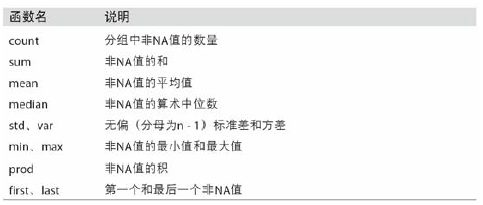

In [6]:
grouped = df.groupby('key1')

In [8]:
grouped['data1'].quantile(0.8) #计算样本分位数

key1
a    0.454930
b    0.951936
Name: data1, dtype: float64

In [9]:
#自定义函数
def peak_to_peak(arr):
    return arr.max() - arr.min()

In [10]:
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,0.493719,3.658514
b,3.093890,0.976017


In [11]:
grouped.aggregate(peak_to_peak)

,data1,data2
key1,,
a,0.493719,3.658514
b,3.093890,0.976017


In [12]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.299229  0.255450  0.014443  0.194762  0.375082  0.441622   
b      2.0  0.023769  2.187711 -1.523176 -0.749704  0.023769  0.797241   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     0.508162   3.0 -0.251644  2.024146 -2.581229 -0.916108  0.749013   
b     1.570714   2.0 -1.252040  0.690149 -1.740048 -1.496044 -1.252040   

                          
           75%       max  
key1                      
a     0.913149  1.077285  
b    -1.008035 -0.764031

### 10.2.1面向列的多函数应用
* 对不同的列，使用不同的聚合函数。

In [13]:
tips = pd.read_csv('tips.csv')
tips.head()

,total_bill,tip,smoker,day,time,size
0,16.99,1.01,No,Sun,Dinner,2
1,10.34,1.66,No,Sun,Dinner,3
2,21.01,3.50,No,Sun,Dinner,3
3,23.68,3.31,No,Sun,Dinner,2
4,24.59,3.61,No,Sun,Dinner,4


In [15]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [16]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [17]:
grouped = tips.groupby(['day','smoker'])

In [19]:
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [20]:
#传入一组函数名，将得到一个DataFrame，其列以函数名命名
grouped_pct.agg(['mean','std',peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

* 对于DataFrame，可以定义一组应用于全部列的一组函数；
或不同的列应用不同的函数

In [21]:

functions = ['count','mean','max']
result = grouped['tip_pct','total_bill'].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

In [22]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

* 对于不同的列，应用不同的函数。
* 方法是： 向agg传入一个从列名映射到函数的字典

In [24]:
#对每个列，应用不同的函数
grouped.agg({'tip':np.max,'size':'sum'})


tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [27]:
#对不同的列，应用不同组的函数
grouped.agg({'tip_pct':['min','max','mean','std'],
           'size':'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

### 10.2.2以没有索引的形式返回聚合
向groupby传入as_index = False。
聚合数据的索引，关闭唯一分组健。

In [28]:
tips.groupby(['day','smoker'],as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


## 10.3apply：一般性的拆分-应用-合并
appy将待处理的对象拆分成多个片段，然后对各个片段调用传入的函数，最后在将各个片段组合到一起。
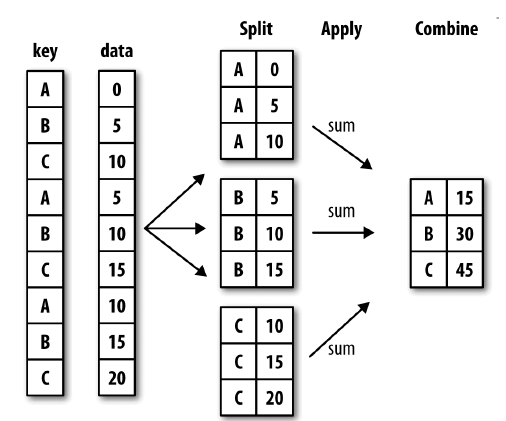

In [37]:
def top(df,n=6,column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [38]:
top(tips)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


### 10.3.1 禁止分组健

### 10.3.2分位数和桶分析

### 10.3.3-5示例

## 10.4 透视表和交叉表
### 10.4.1交叉表：crossrab